In [27]:
import numpy as np
import cartopy.crs as ccrs

# load data
npz = np.load('sstu_d_1993_2022.npz', allow_pickle=True)
print("Keys in the npz file:", npz.keys())
sstum = npz["sstu_d"]
coast = npz["coast"]
lonc = npz["lonc"]
latc = npz["latc"]
time = npz["time"]

npz = np.load('ekman_d_1993_2022.npz', allow_pickle=True)
print("Keys in the npz file:", npz.keys())
last_slice = npz["etransport"][:, :, 0] * 86400             
etransport = np.broadcast_to(last_slice[..., None],          
                             npz["etransport"].shape)
epumpingm = npz["epumping"]*86400

npz = np.load('fesom_core2_fjra_d_1993_2022.npz', allow_pickle=True)
print("Keys in the npz file:", npz.keys())
sstum_fesom = npz["sst"][:,:,8:]-npz["sst"][:,:,:8]

npz = np.load('fesom_core2_fjra_ekman_d_1993_2022.npz', allow_pickle=True)
print("Keys in the npz file:", npz.keys())
last_slice = npz["etransport"][:, :, 0] * 86400             
etransport = np.broadcast_to(last_slice[..., None],          
                             npz["etransport"].shape)
epumpingm_fesom = npz["epumping"]*86400

latitudes = np.mean(latc, axis=1)  
lat_idx = np.where(latitudes < 30)[0]
latitudes = latitudes[lat_idx]
sstum = sstum[:, lat_idx, :]
etransportm = etransportm[:, lat_idx, :]
epumpingm = epumpingm[:, lat_idx, :]
sstum_fesom = sstum_fesom[:,lat_idx,:]
etransportm_fesom = etransportm_fesom[:, lat_idx, :]
epumpingm_fesom = epumpingm_fesom[:, lat_idx, :]

latc = latc[lat_idx, :]
lonc = lonc[lat_idx, :]

lat_bands = [(21, 30), (12, 19)]
masks = [(latc >= lat_min) & (latc <= lat_max) for lat_min, lat_max in lat_bands]
masks_expanded = [np.tile(mask, (sstum.shape[0], 1, 1)) for mask in masks]

sstumb = np.nanmean(np.stack([np.where(mask, sstum, np.nan) for mask in masks_expanded]), axis=(2, 3)) 
etransportmb = np.nanmean(np.stack([np.where(mask, etransportm, np.nan) for mask in masks_expanded]), axis=(2, 3)) 
epumpingmb = np.nanmean(np.stack([np.where(mask, epumpingm, np.nan) for mask in masks_expanded]), axis=(2, 3)) 
sstumb_fesom = np.nanmean(np.stack([np.where(mask, sstum_fesom, np.nan) for mask in masks_expanded]), axis=(2, 3)) 
etransportmb_fesom = np.nanmean(np.stack([np.where(mask, etransportm_fesom, np.nan) for mask in masks_expanded]), axis=(2, 3)) 
epumpingmb_fesom = np.nanmean(np.stack([np.where(mask, epumpingm_fesom, np.nan) for mask in masks_expanded]), axis=(2, 3)) 


# Define time axis (assuming 12 months for seasonal cycle)
days = np.arange(1, sstum.shape[0]+1)
n_regions = 3
sstum.shape

Keys in the npz file: KeysView(NpzFile 'sstu_d_1993_2022.npz' with keys: sstu_d, ssto, coast, lonc, latc...)
Keys in the npz file: KeysView(NpzFile 'ekman_d_1993_2022.npz' with keys: windspeed, etransport, epumping)
Keys in the npz file: KeysView(NpzFile 'fesom_core2_fjra_d_1993_2022.npz' with keys: sst, sss, MLD1, MLD2, MLD3...)
Keys in the npz file: KeysView(NpzFile 'fesom_core2_fjra_ekman_d_1993_2022.npz' with keys: windspeed, etransport, epumping)


(366, 80, 8)

In [28]:
from scipy.stats import pearsonr
import numpy as np
from scipy.stats import linregress


# Maximum lag in months
min_lag = -50
max_lag = 100  
target=sstum

def calculate_seasonal_lagged_correlation(variable1, variable2, min_lag, max_lag, alpha=0.05):
    n_lags = -min_lag + max_lag + 1
    n_lat  = variable2.shape[1]

    lagged_corr = np.full((n_lags, n_lat), np.nan)
    lagged_p    = np.full((n_lags, n_lat), np.nan)

    for lag in range(min_lag, max_lag + 1):
        for lat in range(n_lat):
            var1_shifted = np.roll(variable1[:, lat, :], shift=-lag, axis=0)
            var1_flat = np.nanmean(var1_shifted, axis=-1)
            var2_flat = np.nanmean(variable2[:, lat, :], axis=-1)

            valid_mask = ~np.isnan(var1_flat) & ~np.isnan(var2_flat)
            if np.sum(valid_mask) > 1:
                corr, p = pearsonr(var1_flat[valid_mask], var2_flat[valid_mask])
                lagged_corr[lag - min_lag, lat] = corr
                lagged_p[lag - min_lag, lat] = p

    sig_mask = lagged_p < alpha
    return lagged_corr, lagged_p, sig_mask

# Calculate lagged correlations for each variable
lagged_corr_obs, lagged_p_obs, sig_obs = calculate_seasonal_lagged_correlation(
    sstum, etransportm + epumpingm, min_lag, max_lag
)
lagged_corr_fesom, lagged_p_fesom, sig_fesom = calculate_seasonal_lagged_correlation(
    sstum_fesom, etransportm_fesom + epumpingm_fesom, min_lag, max_lag
)

#lagged_corr_mld = calculate_seasonal_lagged_correlation(target, mldcm, max_lag)


# def lagged_correlation_and_regression(sstumb, inputs_list, max_lead=25, max_lag=25):

#     n_regions, n_days = sstumb.shape

#     # Define lags
#     lags = np.arange(-max_lead, max_lag + 1)

#     # Initialize results dictionary
#     results = {
#         "lags": lags,
#         "correlations": {},
#         "slopes": {}
#     }

#     for input_idx, etransportmb in enumerate(inputs_list):
#         correlations = np.zeros((n_regions, len(lags)))
#         slopes = np.zeros((n_regions, len(lags)))

#         for region in range(n_regions):
#             for i, lag in enumerate(lags):
#                 x = np.roll(etransportmb[region, :], shift=lag, axis=0)
#                 y = sstumb[region, :]
#                 corr, _ = pearsonr(x, y)
#                 correlations[region, i] = corr
#                 slope, _, _, _, _ = linregress(x, y)
#                 slopes[region, i] = slope

#         # Store results for this input
#         results["correlations"][f"input_{input_idx + 1}"] = correlations
#         results["slopes"][f"input_{input_idx + 1}"] = slopes
#     return results

import numpy as np
from scipy.stats import pearsonr, linregress

def lagged_correlation_and_regression(sstumb, inputs_list, max_lead=25, max_lag=25):
    n_regions, n_days = sstumb.shape
    lags = np.arange(-max_lead, max_lag + 1)
    sub_lag_mask = (lags >= -25) & (lags <= 25)


    results = {
        "lags": lags,
        "correlations": {},
        "slopes": {},
        "correlations_sub": {}  # NEW: per-input, per-subperiod arrays for region=1
    }

    for input_idx, etransportmb in enumerate(inputs_list):
        correlations = np.zeros((n_regions, len(lags)))
        slopes = np.zeros((n_regions, len(lags)))

        # NEW: store only for region=1 (second region)
        sub_min_to_max = np.full(len(lags), np.nan)
        sub_max_to_min = np.full(len(lags), np.nan)

        for region in range(n_regions):
            y_full = sstumb[region, :]

            # For region=1, precompute sub-period index arrays once
            if region == 1:
                min_to_max_start = np.argmin(y_full)
                max_to_min_start = np.argmax(y_full)

                min_to_max_idx = (np.arange(min_to_max_start, max_to_min_start + 1) % n_days)
                max_to_min_idx = (np.arange(max_to_min_start, min_to_max_start + n_days + 1) % n_days)

            for i, lag in enumerate(lags):
                x_full = np.roll(etransportmb[region, :], shift=lag, axis=0)

                # Full-period correlation & slope
                corr, _ = pearsonr(x_full, y_full)
                correlations[region, i] = corr
                slope, _, _, _, _ = linregress(x_full, y_full)
                slopes[region, i] = slope

                # NEW: sub-period correlations for region=1 only
                if region == 1 and sub_lag_mask[i]:
                    x1, y1 = x_full[min_to_max_idx], y_full[min_to_max_idx]
                    x2, y2 = x_full[max_to_min_idx], y_full[max_to_min_idx]

                    if len(x1) > 2 and np.std(x1) > 0 and np.std(y1) > 0:
                        sub_min_to_max[i] = pearsonr(x1, y1)[0]
                    if len(x2) > 2 and np.std(x2) > 0 and np.std(y2) > 0:
                        sub_max_to_min[i] = pearsonr(x2, y2)[0]

        key = f"input_{input_idx + 1}"
        results["correlations"][key] = correlations
        results["slopes"][key] = slopes
        results["correlations_sub"][key] = {
            "min_to_max": sub_min_to_max,
            "max_to_min": sub_max_to_min
        }

    return results

results = lagged_correlation_and_regression(sstumb, [etransportmb+epumpingmb, etransportmb_fesom+epumpingmb_fesom], max_lead=50, max_lag=120)


[75 76 77 78 79 80 81 82 83 84]
[-19 -18 -17 -16]
[69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92
 93 94 95]
[-31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14
 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4]


/tmp/ipykernel_4116562/3758733599.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.0, 0.0, 0.85, 1.0])


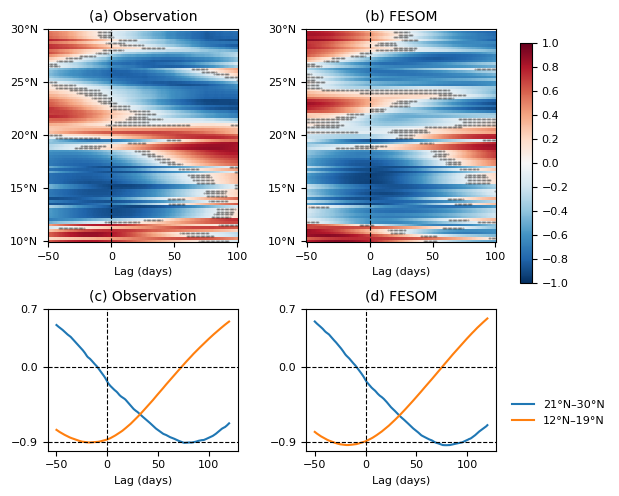

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# --- Data axes ---
lags_top = np.arange(min_lag, max_lag + 1)  # From -5 to 5 months
latitudes = latc[:, 0]  # Assuming latc is latitude data

fig = plt.figure(figsize=(6,5))
gs = GridSpec(2, 2, figure=fig, height_ratios=[3, 2], width_ratios=[1, 1])
plt.rcParams.update({"font.size": 8})

titles_top = ['(a) Observation', '(b) FESOM']
datasets = [lagged_corr_obs, lagged_corr_fesom]
sig_masks = [sig_obs, sig_fesom]  # significance masks

axes_top = []
mappable = None

for i, (data, sig, title) in enumerate(zip(datasets, sig_masks, titles_top)):
    ax = fig.add_subplot(gs[0, i])
    axes_top.append(ax)

    # main heatmap
    c = ax.pcolormesh(
        lags_top, latitudes, data.T,
        shading='auto', cmap='RdBu_r', vmin=-1, vmax=1
    )
    mappable = c

    # === Add dots to non-significant ===
    nonsig = ~sig.T  # boolean mask
    L, LAT = np.meshgrid(lags_top, latitudes)

    ax.scatter(
        L[nonsig], LAT[nonsig],
        s=1, color='black', marker='.',
        alpha=0.3
    )

    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Lag (days)')
    ax.set_yticks(np.arange(np.min(latitudes), np.max(latitudes) + 1, 5))
    ax.set_yticklabels([f'{int(lat)}°N'
                        for lat in np.arange(np.min(latitudes), np.max(latitudes) + 1, 5)])
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
# one shared colorbar for (a) and (b) on the right 
cbar = fig.colorbar(mappable, ax=axes_top, orientation='vertical') 
cbar.ax.set_position([0.87, 0.42, 0.02, 0.5]) 
cbar.set_ticks(np.linspace(-1, 1, 11))
lat_bands = [(21, 30), (12, 19)]
lags_bottom = np.arange(-50, 121)
titles_bottom = ['(c) Observation', '(d) FESOM']

axes_bottom = []

lags_bottom = results["lags"]  # ensure consistent

for input_idx, title in enumerate(titles_bottom):  # 0: obs, 1: fesom
    ax = fig.add_subplot(gs[1, input_idx])
    axes_bottom.append(ax)

    for region in range(2):
        corr = results["correlations"][f"input_{input_idx + 1}"][region, :]

        lat0, lat1 = lat_bands[region]

        # Plot full period, capture line color
        (line_full,) = ax.plot(lags_bottom, corr, label=f"{lat0}°N–{lat1}°N")
        c = line_full.get_color()

        # # Sub-period lines ONLY for second region (region index 1)
        # if region == 1:
        #     sub = results["correlations_sub"][f"input_{input_idx + 1}"]
        #     ax.plot(lags_bottom, sub["min_to_max"], color=c, linestyle="--", linewidth=1)
        #     ax.plot(lags_bottom, sub["max_to_min"], color=c, linestyle=":",  linewidth=1)
        #     sub = results["correlations_sub"][f"input_{input_idx + 1}"]

        #     mask25 = (lags_bottom >= -25) & (lags_bottom <= 25)
        #     # min → max
        #     mask_sub1 = (sub["min_to_max"] < -0.9) & mask25
        #     if np.any(mask_sub1):
        #         print(f"{title} | Region 2 | min→max corr<-0.9 at lags:")
        #         print(lags_bottom[mask_sub1])

        #         sub = results["correlations_sub"][f"input_{input_idx + 1}"]
        #         mask25 = (lags_bottom >= -25) & (lags_bottom <= 25)

        #         sub2 = sub["max_to_min"].copy()
        #         sub2[~mask25] = np.nan  # ignore outside [-25,25]

        #         i_min = np.nanargmin(sub2)
        #         print(f"{title} | Region 2 | max→min minimum corr at lag {lags_bottom[i_min]} days: {sub2[i_min]:.3f}")



        # your debug print
        mask = corr < -0.90
        print(lags_bottom[mask])

    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.8)
    ax.axhline(-0.9, color='black', linestyle='--', linewidth=0.8)

    ax.set_ylim([-1, 0.7])
    ax.set_yticks([-0.9, 0, 0.7])
    ax.set_xlabel('Lag (days)')
    ax.set_title(title, fontsize=10)

# build a single legend from the bottom-left axis and put it on the right
handles, labels_legend = axes_bottom[0].get_legend_handles_labels()
fig.legend(
    handles, labels_legend,
    loc='center left',
    bbox_to_anchor=(0.84, 0.17),  # tweak y if needed
    frameon=False
)

# leave room on the right for colorbar + legend
plt.tight_layout(rect=[0.0, 0.0, 0.85, 1.0])
plt.savefig("fig3.png", dpi=300, bbox_inches='tight')
plt.show()
